In [5]:
import re, gensim, gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk, spacy, pandas as pd
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import pyLDAvis.gensim, pyLDAvis
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

In [7]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('stopwords')
stop_words = stopwords.words('english') + ['from','subject','re','edu','use']
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df = pd.read_csv('uci-news-aggregator.csv', encoding='ISO-8859-1')
print(df.columns)  # Check this once
data = df['TITLE'].astype(str).tolist()

Index(['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME',
       'TIMESTAMP'],
      dtype='object')


# TEXT **CLEANING**

In [14]:
def clean(texts):
    texts = [re.sub('\S*@\S*\s?', '', t) for t in texts]
    texts = [re.sub('\s+', ' ', t) for t in texts]
    texts = [re.sub("\'", "", t) for t in texts]
    return texts

In [15]:
data = clean(data)

# Tokenize & **Preprocessing**

In [16]:
data_words = [simple_preprocess(str(sent), deacc=True) for sent in data]

bigram = gensim.models.Phrases(data_words, min_count=50, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_bigrams = [bigram_mod[doc] for doc in data_words]

In [20]:
def lemmatize(texts, allowed_pos=['NOUN','ADJ','VERB','ADV']):
    out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        out.append([token.lemma_ for token in doc if token.pos_ in allowed_pos])
    return out


In [21]:
data_sample = data_bigrams[:5000]  # Just 5k rows
data_lemm = lemmatize(data_sample)

# Stopword **Removal**

In [22]:
data_nostops = [[w for w in doc if w not in stop_words] for doc in data_lemm]


# Dictionary & **Corpus**

In [23]:
id2word = corpora.Dictionary(data_nostops)
corpus = [id2word.doc2bow(text) for text in data_nostops]

# **LDA** Model

In [34]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    scores = []
    models = []
    for num in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        scores.append(coherencemodel.get_coherence())
        models.append(model)
    return models, scores

models, scores = compute_coherence_values(id2word, corpus, data_nostops, start=5, limit=31, step=5)

# Evaluate & Visualize **Topics**

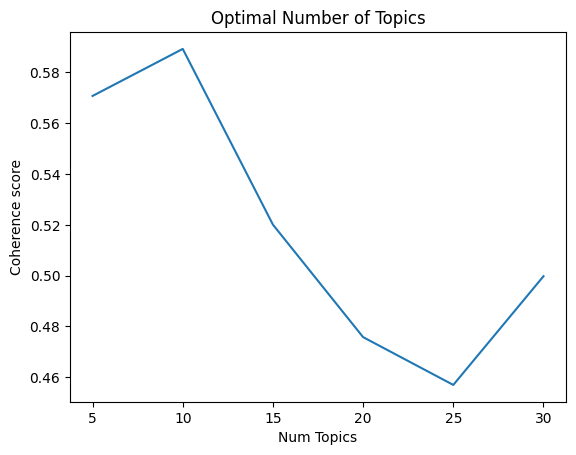

In [35]:
import matplotlib.pyplot as plt
x = range(5, 31, 5)
plt.plot(x, scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Optimal Number of Topics")
plt.show()

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.222800 -0.123978       1        1  14.207796
6      0.247583 -0.273068       2        1  11.534714
4     -0.116782 -0.022773       3        1  10.747781
8     -0.024287  0.066700       4        1  10.574688
3     -0.135443 -0.071857       5        1  10.026444
5     -0.076705  0.029417       6        1   9.068335
9      0.144607  0.086324       7        1   8.620152
1      0.048035  0.155045       8        1   8.612400
2      0.062655 -0.024926       9        1   8.311227
0      0.073139  0.179115      10        1   8.296462, topic_info=               Term        Freq       Total Category  logprob  loglift
1045          video  170.000000  170.000000  Default  30.0000  30.0000
2288       bachelor  193.000000  193.000000  Default  29.0000  29.0000
2               say  144.000000  144.000000  Default  28.0000  28.0000
267          season  168.000000  168.000000  Default  27.0000  27.0000
18            stock  132.000000  132.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1749           read   18.938434   26.749229  Topic10  -4.6887   2.1440
2911  justin_bieber   33.843548   73.839208  Topic10  -4.1082   1.7092
1510           tech   17.174131   29.063874  Topic10  -4.7865   1.9632
3598         carney   22.597103   98.991423  Topic10  -4.5121   1.0121
3051         marrie   15.051827   37.673253  Topic10  -4.9184   1.5719

[420 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
604       1  0.942267         add
69        9  0.954302       ahead
1409      5  0.946018  allegation
620       9  0.962684    american
623       4  0.975913     analyst
...     ...       ...         ...
723       5  0.157158       world
723       9  0.373251       world
98        2  0.958212       worry
115       6  0.986453        year
2034      7  0.931594       young

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 5, 9, 4, 6, 10, 2, 3, 1])

# Topic Distributions + K-**Means**

In [29]:
num_topics = lda_model.num_topics

topic_dist = np.zeros((len(corpus), num_topics))

for i, doc in enumerate(corpus):
    for topic_id, prob in lda_model.get_document_topics(doc):
        topic_dist[i, topic_id] = prob

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(topic_dist)

# **Dimensionality** Reduction & Plot

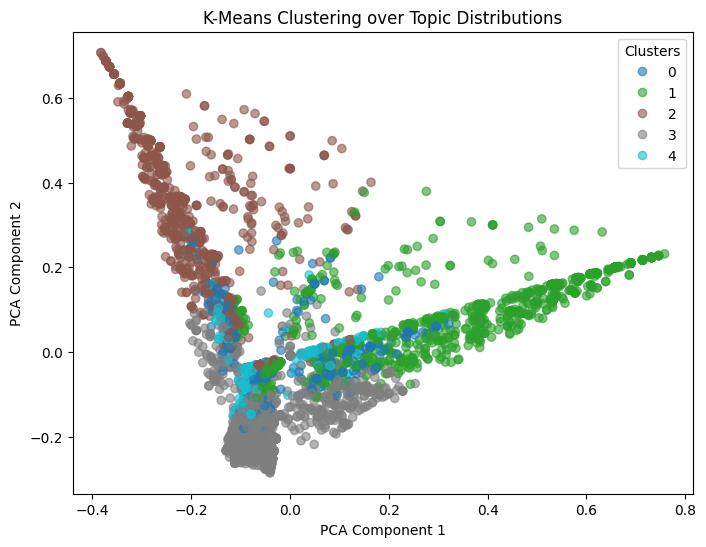

In [31]:
coords = PCA(n_components=2).fit_transform(topic_dist)
plt.figure(figsize=(8,6))
scatter = plt.scatter(coords[:,0], coords[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering over Topic Distributions")
plt.show()

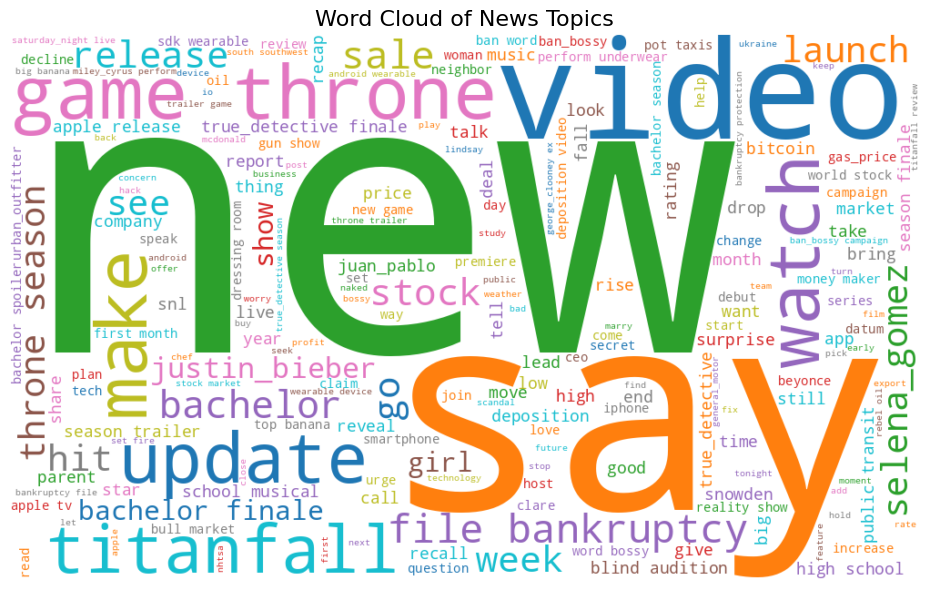

In [33]:
from wordcloud import WordCloud

all_words = [word for doc in data_nostops for word in doc]
text = ' '.join(all_words)

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='tab10',
    max_words=200
).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Topics", fontsize=16)
plt.tight_layout()
plt.show()
